Данные: Набор изображений из Google Street View с изображениями номеров домов, содержащий 10 классов, соответствующих цифрам от 0 до 9.
73257 изображений цифр в обучающей выборке;
26032 изображения цифр в тестовой выборке;
531131 изображения, которые можно использовать как дополнение к обучающей выборке;
В двух форматах:
o   Оригинальные изображения с выделенными цифрами;
o   Изображения размером 32 × 32, содержащих одну цифру;
Данные первого формата можно скачать по ссылкам:
o   http://ufldl.stanford.edu/housenumbers/train.tar.gz (обучающая выборка);
o   http://ufldl.stanford.edu/housenumbers/test.tar.gz (тестовая выборка);
o   http://ufldl.stanford.edu/housenumbers/extra.tar.gz (дополнительные данные);
Данные второго формата можно скачать по ссылкам:
o   http://ufldl.stanford.edu/housenumbers/train_32x32.mat (обучающая выборка);
o   http://ufldl.stanford.edu/housenumbers/test_32x32.mat (тестовая выборка);
o   http://ufldl.stanford.edu/housenumbers/extra_32x32.mat (дополнительные данные);
Описание данных на английском языке доступно по ссылке:
o   http://ufldl.stanford.edu/housenumbers/

Задание 1.
Реализуйте глубокую нейронную сеть (полносвязную или сверточную) и обучите ее на синтетических данных (например, наборы MNIST (http://yann.lecun.com/exdb/mnist/) или notMNIST).
Ознакомьтесь с имеющимися работами по данной тематике: англоязычная статья (http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf), видео на YouTube (https://www.youtube.com/watch?v=vGPI_JvLoN0).

In [0]:
pwd

'/content'

In [0]:
mkdir 4_housenumbers

mkdir: cannot create directory ‘4_housenumbers’: File exists


In [0]:
cd 4_housenumbers/

/content/4_housenumbers


In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf


import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


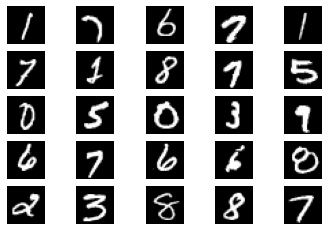

In [0]:
rand_indexes = np.random.randint(0, X_test.shape[0], 25)

plt.figure()
for i in range(len(rand_indexes)):
    img = X_train[rand_indexes[i]]

    plt.subplot(5, 5, i + 1)
    plt.axis('off')
    plt.imshow(img, cmap='gray')

plt.show()

Synthetic data generation

In [0]:
MAX_DIGIT_COUNT = 5

In [0]:
def generate_synth_data(X, y, number_count=None, digit_count=MAX_DIGIT_COUNT):
    if number_count is None:
        number_count = len(X)

    img_count, img_height, img_width = X.shape
    synth_numbers, labels = [], []

    for _ in range(number_count):
        curr_digit_count = np.random.randint(1, digit_count + 1)
        offset = np.random.randint(0, digit_count - curr_digit_count + 1)
        label = [10] * digit_count
        number = np.zeros((img_height, img_width * digit_count))
        for i in range(offset, offset + curr_digit_count):
            img_index = np.random.randint(0, img_count - 1)
            rand_digit = X[img_index]
            label[i] = y[img_index]
            number[:, i * img_width: (i + 1) * img_width] = rand_digit

        synth_numbers.append(number)
        labels.append(label)

    return np.array(synth_numbers), np.array(labels)

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


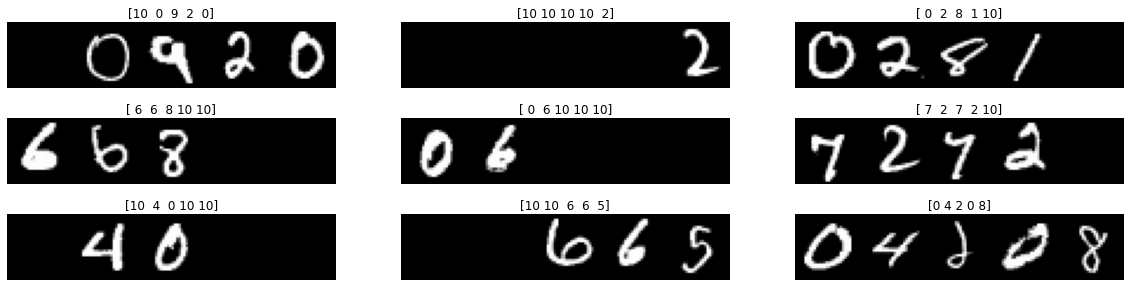

In [0]:
synth_x_train, synth_y_train = generate_synth_data(X_train, y_train)


plt.figure(figsize=(20, 5))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.axis('off')
    plt.title(synth_y_train[i])
    plt.imshow(synth_x_train[i], cmap='gray')


Model building based on http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf 

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [0]:
def get_model(input_shape=(28, 28 * MAX_DIGIT_COUNT, 1), p=0.5, n_class=11):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.BatchNormalization()(inputs)
    x = tf.keras.layers.Conv2D(48, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Dropout(p/4)(x)
        
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    x = tf.keras.layers.Dropout(p/4)(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(128, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Dropout(p/2)(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(160, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    x = tf.keras.layers.Dropout(p/2)(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Dropout(p)(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    x = tf.keras.layers.Dropout(p)(x)
        
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(3072, activation='relu')(x)
    x = tf.keras.layers.Dense(3072, activation='relu')(x)

    o1 = tf.keras.layers.Dense(n_class, activation='softmax')(x)
    o2 = tf.keras.layers.Dense(n_class, activation='softmax')(x)
    o3 = tf.keras.layers.Dense(n_class, activation='softmax')(x)
    o4 = tf.keras.layers.Dense(n_class, activation='softmax')(x)
    o5 = tf.keras.layers.Dense(n_class, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=[o1, o2, o3, o4, o5])

    return model

In [0]:
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 140, 1)] 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 140, 1)   4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 140, 48)  1248        batch_normalization[0][0]        
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 14, 70, 48)   0           conv2d[0][0]                     
______________________________________________________________________________________________

In [0]:
model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history = model.fit(
    synth_x_train, 
    [synth_y_train.T[i] for i in range(MAX_DIGIT_COUNT)], 
    batch_size=128, 
    epochs=3, 
    validation_split=0.2
)

Epoch 1/3
375/375 [==============================] - 77s 206ms/step - loss: 3.9436 - dense_2_loss: 0.6702 - dense_3_loss: 0.8617 - dense_4_loss: 0.9079 - dense_5_loss: 0.8563 - dense_6_loss: 0.6475 - dense_2_accuracy: 0.7775 - dense_3_accuracy: 0.7025 - dense_4_accuracy: 0.6746 - dense_5_accuracy: 0.6977 - dense_6_accuracy: 0.7700 - val_loss: 2.3080 - val_dense_2_loss: 0.2729 - val_dense_3_loss: 0.6077 - val_dense_4_loss: 0.5936 - val_dense_5_loss: 0.5326 - val_dense_6_loss: 0.3013 - val_dense_2_accuracy: 0.9423 - val_dense_3_accuracy: 0.8514 - val_dense_4_accuracy: 0.8608 - val_dense_5_accuracy: 0.8858 - val_dense_6_accuracy: 0.9342
Epoch 2/3
375/375 [==============================] - 75s 200ms/step - loss: 0.2859 - dense_2_loss: 0.0482 - dense_3_loss: 0.0599 - dense_4_loss: 0.0641 - dense_5_loss: 0.0597 - dense_6_loss: 0.0539 - dense_2_accuracy: 0.9872 - dense_3_accuracy: 0.9846 - dense_4_accuracy: 0.9834 - dense_5_accuracy: 0.9836 - dense_6_accuracy: 0.9856 - val_loss: 0.1278 - val_

In [0]:
def plot_loss(fit_hist):
    epoch_count = len(fit_hist.history['loss'])
    plt.plot(np.arange(1, epoch_count + 1), fit_hist.history['loss'], label="Train")
    plt.plot(np.arange(1, epoch_count + 1), fit_hist.history['val_loss'], label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

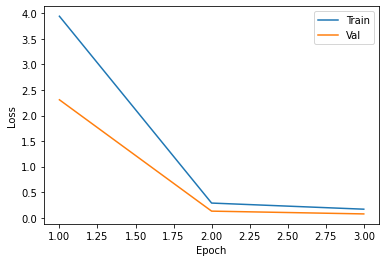

In [0]:
plot_loss(history)

As we see, the model we've got is pretty accurate.

In [0]:
synth_x_test, synth_y_test = generate_synth_data(X_test, y_test)

In [0]:
model.evaluate(
    synth_x_test, 
    [synth_y_test.T[i] for i in range(MAX_DIGIT_COUNT)]
)

313/313 [==============================] - 8s 25ms/step - loss: 0.1303 - dense_2_loss: 0.0227 - dense_3_loss: 0.0204 - dense_4_loss: 0.0396 - dense_5_loss: 0.0231 - dense_6_loss: 0.0246 - dense_2_accuracy: 0.9966 - dense_3_accuracy: 0.9947 - dense_4_accuracy: 0.9932 - dense_5_accuracy: 0.9949 - dense_6_accuracy: 0.9960


[0.1303495168685913,
 0.02269529365003109,
 0.020404217764735222,
 0.03962887451052666,
 0.023068269714713097,
 0.02455284260213375,
 0.9965999722480774,
 0.994700014591217,
 0.9932000041007996,
 0.9948999881744385,
 0.9959999918937683]

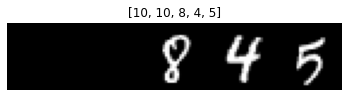

In [0]:
test_elem = synth_x_test[np.random.randint(len(synth_x_test))]
prediction = model.predict(test_elem.reshape((1, *test_elem.shape, 1)))
plt.title([np.argmax(prediction[i]) for i in range(MAX_DIGIT_COUNT)])
plt.imshow(test_elem, cmap='gray')
plt.axis('off')
plt.show()

Задание 2.

После уточнения модели на синтетических данных попробуйте обучить ее на реальных данных (набор Google Street View). Что изменилось в модели?

In [0]:
!wget http://ufldl.stanford.edu/housenumbers/train.tar.gz
!wget http://ufldl.stanford.edu/housenumbers/test.tar.gz
!tar xvfz train.tar.gz
!tar xvfz test.tar.gz
!rm -rf train.tar.gz
!rm -rf test.tar.gz

Streaming output truncated to the last 5000 lines.
test/2554.png
test/2550.png
test/2549.png
test/2535.png
test/2528.png
test/2519.png
test/2516.png
test/2510.png
test/2504.png
test/2494.png
test/2491.png
test/2485.png
test/2477.png
test/2470.png
test/2432.png
test/2390.png
test/2385.png
test/2351.png
test/2339.png
test/2320.png
test/2316.png
test/2315.png
test/2296.png
test/2279.png
test/2271.png
test/2258.png
test/2249.png
test/2245.png
test/2229.png
test/2209.png
test/2197.png
test/2192.png
test/2190.png
test/2186.png
test/2178.png
test/2175.png
test/2157.png
test/2154.png
test/2150.png
test/2148.png
test/2128.png
test/2126.png
test/2116.png
test/2103.png
test/2077.png
test/2061.png
test/2047.png
test/2015.png
test/1945.png
test/1939.png
test/1903.png
test/1869.png
test/1859.png
test/1847.png
test/1836.png
test/1826.png
test/1817.png
test/1804.png
test/1796.png
test/1791.png
test/1783.png
test/1773.png
test/1764.png
test/1744.png
test/1718.png
test/1680.png
test/1678.png
test/1667.p

In [0]:
import pathlib
train_dir = pathlib.Path('./train/')
test_dir = pathlib.Path('./test/')

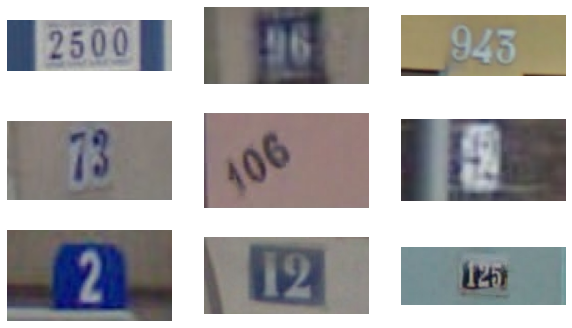

In [0]:
from PIL import Image

f = plt.figure(figsize=(10, 6))
for i, fn in enumerate(np.random.choice(list(train_dir.glob('*.png')), 9)):
    f.add_subplot(3, 3, i + 1)
    plt.imshow(Image.open(fn, mode='r'))
    plt.axis('off')
plt.show()

Images have different size. Let's process them to be the same size.


In [0]:
TRAIN_IMG_H, TRAIN_IMG_W = 64, 64
STRUCT_FILENAME = 'digitStruct.mat'
import h5py
import cv2

In [0]:
def get_files_structure(filepath):
    f = h5py.File(filepath, 'r')

    dict = {
        'filename': [],
        'label': [],
        'img_metadata': [],  # coordinates of digits
        'size': 0,
    }

    name = f['/digitStruct/name']
    bbox = f['/digitStruct/bbox']

    def get_int_value(attr):
        return int(attr[0][0])

    def get_attr(f, i, key):
        ref = f[bbox[i].item()][key]
        if len(ref) > 1:
            return [get_int_value(f[ref[j].item()]) for j in range(len(ref))]
        else:
            return [get_int_value(ref)]

    size = len(name)
    dict['size'] = size
    for i in range(size):
        dict['filename'].append(''.join([chr(v[0]) for v in f[name[i][0]]]))
        dict['label'].append(get_attr(f, i, 'label'))
        img_metadata = {}
        for k in ['height', 'width', 'left', 'top']:
            img_metadata[k] = get_attr(f, i, k)
        dict['img_metadata'].append(img_metadata)

    return dict

In [0]:
def crop_img(img, img_metadata, expand=None):
    img_height, img_width, _ = img.shape

    left = np.min(img_metadata['left'])
    top = np.min(img_metadata['top'])
    bottom = np.max(img_metadata['top']) + np.max(img_metadata['height'])
    right = np.max(img_metadata['left']) + np.max(img_metadata['width'])

    box_width = right - left
    box_height = bottom - top

    if expand is not None:
        left = np.max((0, int(left - box_width * expand)))
        top = np.max((0, int(top - box_height * expand)))
        bottom = np.min((img_height, int(bottom + box_height * expand)))
        right = np.min((img_width, int(right + box_width * expand)))

    return img[top:bottom, left:right, :].copy()


def rescale_img(img, size):
    return cv2.resize(img, size)


def get_processed_label(label, using_len=True):
    label_len = len(label)
    if label_len > MAX_DIGIT_COUNT:
        raise Exception('Incorrect label: ' + label)
    labels = [l if l != 10 else 0 for l in label]
    labels.extend([10] * (MAX_DIGIT_COUNT - label_len))
    if using_len:
        labels.append(label_len)
    return labels


def get_processed_ds(root, rescale=(TRAIN_IMG_W, TRAIN_IMG_H), img_expand=None):
    X, y = [], []
    struct = get_files_structure(root + STRUCT_FILENAME)
    for i in range(struct['size']):
        img = cv2.imread(root + struct['filename'][i], cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        try:
            l = get_processed_label(struct['label'][i])
            cropped_img = crop_img(img, struct['img_metadata'][i], img_expand)
            rescaled_img = rescale_img(cropped_img, rescale)
            rescaled_img = rescaled_img / 255
        except Exception as e:
            print(e)
            continue

        X.append(rescaled_img)
        y.append(l)

    return np.array(X), np.array(y)

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion faile

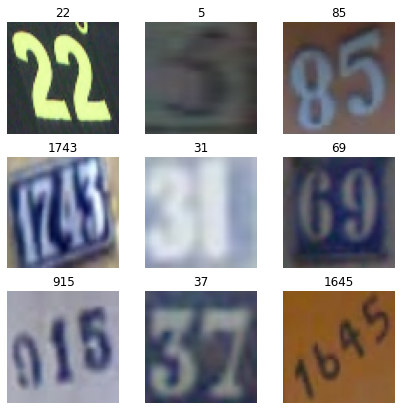

In [0]:
X_train, y_train = get_processed_ds('./train/')
print(X_train.shape, y_train.shape)

fig = plt.figure(figsize=(7, 7))
for i in range(1, 10):
    ax = fig.add_subplot(3, 3, i)
    img_ind = np.random.randint(0, len(X_train) - 1)
    ax.set_title("".join([str(i) for i in y_train[img_ind][:-1] if i != 10]))
    ax.set_axis_off()
    plt.imshow(X_train[img_ind])

Let's build the model as the previous one, but with an additional output layer - count of digits.

In [0]:
def get_model(input_shape=(TRAIN_IMG_H, TRAIN_IMG_W, 3), p=0.5, n_class=11):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.BatchNormalization()(inputs)
    x = tf.keras.layers.Conv2D(48, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Dropout(p/4)(x)
        
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    x = tf.keras.layers.Dropout(p/4)(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(128, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Dropout(p/2)(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(160, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    x = tf.keras.layers.Dropout(p/2)(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Dropout(p)(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    x = tf.keras.layers.Dropout(p)(x)
        
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(3072, activation='relu')(x)
    x = tf.keras.layers.Dense(3072, activation='relu')(x)

    o1 = tf.keras.layers.Dense(n_class, activation='softmax')(x)
    o2 = tf.keras.layers.Dense(n_class, activation='softmax')(x)
    o3 = tf.keras.layers.Dense(n_class, activation='softmax')(x)
    o4 = tf.keras.layers.Dense(n_class, activation='softmax')(x)
    o5 = tf.keras.layers.Dense(n_class, activation='softmax')(x)
    o_len = tf.keras.layers.Dense(MAX_DIGIT_COUNT + 1, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=[o1, o2, o3, o4, o5, o_len])

    return model

In [0]:
model = get_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 64, 64, 3)    12          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 64, 64, 48)   3648        batch_normalization_6[0][0]      
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 32, 32, 48)   0           conv2d_6[0][0]                   
____________________________________________________________________________________________

Epoch 1/25
209/209 [==============================] - 49s 236ms/step - loss: 8.8470 - dense_9_loss: 2.6867 - dense_10_loss: 2.7769 - dense_11_loss: 1.5386 - dense_12_loss: 0.3922 - dense_13_loss: 0.0271 - dense_14_loss: 1.4256 - dense_9_accuracy: 0.2613 - dense_10_accuracy: 0.1824 - dense_11_accuracy: 0.6853 - dense_12_accuracy: 0.9528 - dense_13_accuracy: 0.9949 - dense_14_accuracy: 0.5638 - val_loss: 7.7633 - val_dense_9_loss: 1.9989 - val_dense_10_loss: 2.4785 - val_dense_11_loss: 1.6093 - val_dense_12_loss: 0.4374 - val_dense_13_loss: 0.0078 - val_dense_14_loss: 1.2313 - val_dense_9_accuracy: 0.2839 - val_dense_10_accuracy: 0.1227 - val_dense_11_accuracy: 0.5904 - val_dense_12_accuracy: 0.9542 - val_dense_13_accuracy: 0.9999 - val_dense_14_accuracy: 0.4566
Epoch 2/25
209/209 [==============================] - 46s 222ms/step - loss: 5.6534 - dense_9_loss: 1.7653 - dense_10_loss: 1.9996 - dense_11_loss: 1.0239 - dense_12_loss: 0.2169 - dense_13_loss: 0.0037 - dense_14_loss: 0.6439 - 

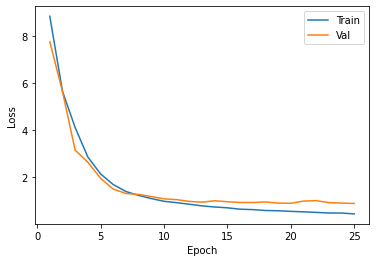

In [0]:
model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history = model.fit(
    X_train, 
    [y_train.T[i] for i in range(MAX_DIGIT_COUNT + 1)], 
    batch_size=128, 
    epochs=25, 
    validation_split=0.2
)
plot_loss(history)

In [0]:
X_test, y_test = get_processed_ds('./test/')
print(X_test.shape, y_test.shape)

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion faile

In [0]:
model.evaluate(
    X_test, 
    [y_test.T[i] for i in range(MAX_DIGIT_COUNT + 1)]
)

409/409 [==============================] - 11s 28ms/step - loss: 0.7677 - dense_9_loss: 0.2505 - dense_10_loss: 0.2917 - dense_11_loss: 0.1127 - dense_12_loss: 0.0199 - dense_13_loss: 0.0027 - dense_14_loss: 0.0902 - dense_9_accuracy: 0.9343 - dense_10_accuracy: 0.9272 - dense_11_accuracy: 0.9737 - dense_12_accuracy: 0.9958 - dense_13_accuracy: 0.9996 - dense_14_accuracy: 0.9740


[0.7677127718925476,
 0.250537246465683,
 0.2917349338531494,
 0.11268240213394165,
 0.01992003619670868,
 0.002655127551406622,
 0.0901828184723854,
 0.9343032240867615,
 0.9271822571754456,
 0.9736600518226624,
 0.9957886934280396,
 0.9996171593666077,
 0.9740428924560547]

In [0]:
# from sklearn.metrics import accuracy_score

# def convert_true_labels(y):
#     output = []
#     for labels in y:
#         int_labels = [int(i) for i in labels[:-1]]
#         str_labels = [str(i) for i in int_labels if i != 10]
#         str_digit = "".join(str_labels)
#         output.append(str_digit)

#     return output

# def predict(x, model):
#       prediction = model.predict(x)
#       lengths = prediction[0]
#       labels = np.array(prediction[:-1]).swapaxes(0, 1)
      
#       output = []
#       for i in range(len(lengths)):
#           digit_preds = labels[i]
#           elem_pred = [np.argmax(digit_preds[j]) for j in range(MAX_DIGIT_COUNT)]
#           str_digit = "".join([str(i) for i in elem_pred if i != 10])
#           output.append(str_digit)
      
#       return output


# true_labels = convert_true_labels(y_test)
# predicted_labels = predict(X_test, model)
# score = accuracy_score(true_labels, predicted_labels)
# print(f'Accuracy score: {score}')

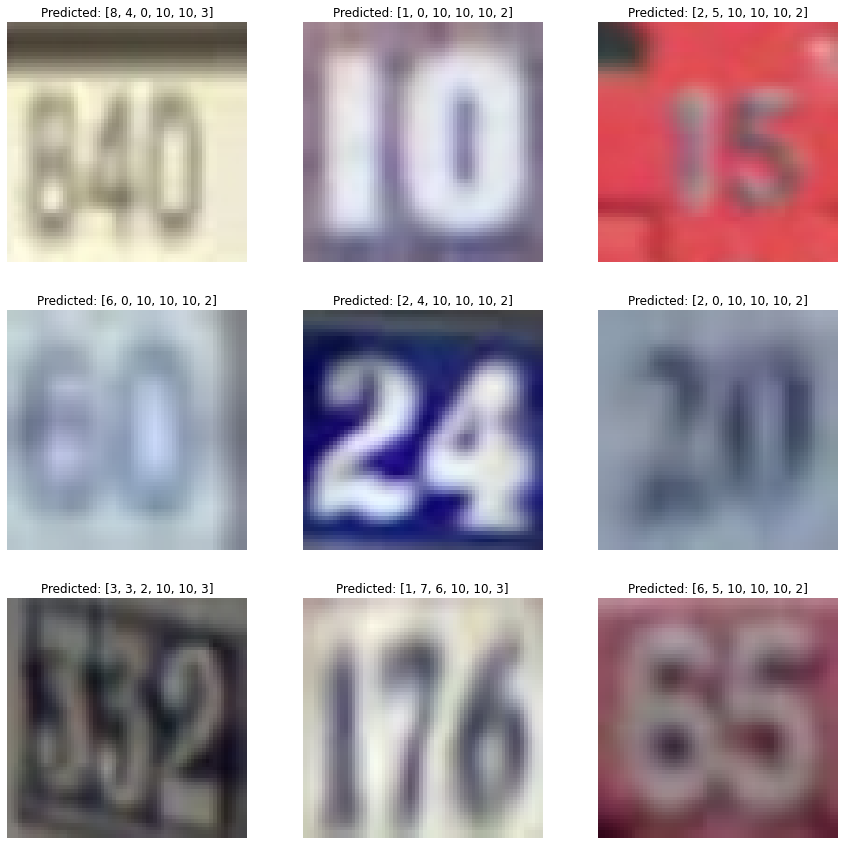

In [0]:
img_indexes = np.random.randint(1, len(X_test), 9)

fig = plt.figure(figsize=(15, 15))
for i in range(1, 10):
    ax = fig.add_subplot(3, 3, i)
    img_ind = img_indexes[i - 1]
    prediction = model.predict(X_test[img_ind].reshape((1, *X_test[img_ind].shape)))
    ax.set_title(f'Predicted: {[np.argmax(prediction[j]) for j in range(MAX_DIGIT_COUNT + 1)]}')
    ax.set_axis_off()
    plt.imshow(X_test[img_ind])
plt.show()

Сделайте множество снимков изображений номеров домов с помощью смартфона на ОС Android. Также можно использовать библиотеки OpenCV, Simple CV или Pygame для обработки изображений с общедоступных камер видеонаблюдения (например, https://www.earthcam.com/).
Пример использования библиотеки TensorFlow на смартфоне можете воспользоваться демонстрационным приложением от Google (https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android).


In [0]:
from google.colab import files
uploaded = files.upload()
!unzip mo_photos.zip -d photos

Archive:  mo_photos.zip
   creating: photos/mo_photos/
  inflating: photos/mo_photos/3_1.png  
  inflating: photos/__MACOSX/mo_photos/._3_1.png  
  inflating: photos/mo_photos/1_3.png  
  inflating: photos/__MACOSX/mo_photos/._1_3.png  
  inflating: photos/mo_photos/1_2.png  
  inflating: photos/__MACOSX/mo_photos/._1_2.png  
  inflating: photos/mo_photos/3_2.png  
  inflating: photos/__MACOSX/mo_photos/._3_2.png  
  inflating: photos/mo_photos/1_1.png  
  inflating: photos/__MACOSX/mo_photos/._1_1.png  
  inflating: photos/mo_photos/2_2.png  
  inflating: photos/__MACOSX/mo_photos/._2_2.png  
  inflating: photos/mo_photos/2_3.png  
  inflating: photos/__MACOSX/mo_photos/._2_3.png  
  inflating: photos/mo_photos/2_1.png  
  inflating: photos/__MACOSX/mo_photos/._2_1.png  
  inflating: photos/mo_photos/4_2.png  
  inflating: photos/__MACOSX/mo_photos/._4_2.png  
  inflating: photos/mo_photos/4_1.png  
  inflating: photos/__MACOSX/mo_photos/._4_1.png  


In [0]:
X = []
for fn in pathlib.Path('./photos/mo_photos').glob('*.png'):
    img = cv2.imread(str(fn), cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    rescaled_img = rescale_img(img, (64, 64))
    rescaled_img = rescaled_img / 255
    X.append(rescaled_img)
X = np.array(X)
X.shape

(10, 64, 64, 3)

Реализуйте приложение для ОС Android, которое может распознавать цифры в номерах домов, используя разработанный ранее классификатор. Какова доля правильных классификаций?

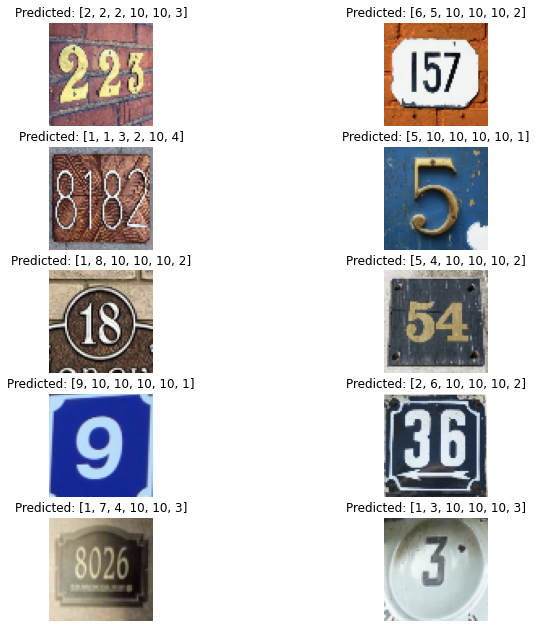

In [0]:
fig = plt.figure(figsize=(11, 11))
for i in range(1, len(X) + 1):
    ax = fig.add_subplot(5, 2, i)
    X_curr = X[i - 1]
    prediction = model.predict(X_curr.reshape((1, *X_curr.shape)))
    ax.set_title(f'Predicted: {[np.argmax(prediction[j]) for j in range(MAX_DIGIT_COUNT + 1)]}')
    ax.set_axis_off()
    plt.imshow(X_curr)
plt.show()

As the train dataset mostly contains 1-&-2 digit numbers, the pictures with such a count of digits are predicted better than the others.